In [2]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from src.path_loss import PathLossInHIndoorOffice, PathLossInHShoppingMalls
from src.network_sim import NetworkSimulator
from src.algorithm import wmmse
from src.sc import SyntheticControl

%reload_ext autoreload
%autoreload 2
%aimport src

In [3]:
frequency_Hz= 50 * 1e9 # Hz
distance_m = 50
sample_size = 10

In [4]:
pd.DataFrame({
    'PathLossInHIndoorOffice':[PathLossInHIndoorOffice().in_dBm(frequency_Hz=frequency_Hz, distance_m=distance_m) for i in range(sample_size)],
    'PathLossInHShoppingMalls': [PathLossInHShoppingMalls().in_dBm(frequency_Hz=frequency_Hz, distance_m=distance_m) for i in range(sample_size)],
})

,PathLossInHIndoorOffice,PathLossInHShoppingMalls
0,-125.549711,-102.680151
1,-135.884556,-113.660575
2,-119.117274,-102.456709
3,-133.794549,-117.690479
4,-129.868340,-110.447279
5,-114.536864,-95.923689
6,-126.399550,-108.244133
7,-125.855869,-100.564212
8,-124.537846,-102.473276
9,-116.856493,-102.112441


In [493]:
simulator = NetworkSimulator(Tx_radius=100, Rx_radius=25, num_Tx_known=2, num_Rx_per_Tx_known=5, num_Tx_unknown=1, num_Rx_per_Tx_unknown=5)

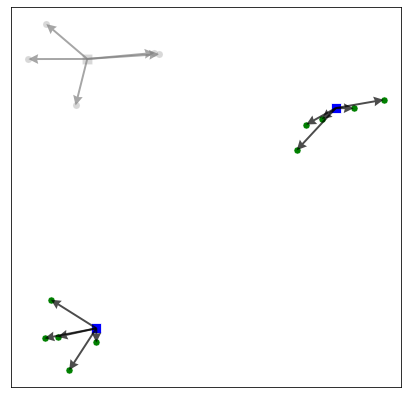

In [494]:
simulator.plot_network()

In [495]:
pd.DataFrame(simulator.gain_mat_dBm)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,-90.667972,-99.433288,-96.226795,-107.306727,-97.540807,-132.843612,-116.705127,-128.841459,-109.634111,-137.063340,-123.127454,-122.694067,-141.371116,-130.494297,-113.330238
1,-128.762943,-134.491306,-136.039960,-149.308190,-126.389862,-83.125795,-88.451502,-83.556206,-109.356517,-105.197512,-114.406552,-109.590406,-128.028917,-123.094949,-115.220511
2,-116.942929,-136.121272,-133.758883,-133.316233,-128.201267,-112.968871,-113.709415,-110.306025,-107.650115,-115.880964,-90.683189,-104.255919,-100.679762,-99.891566,-116.986767


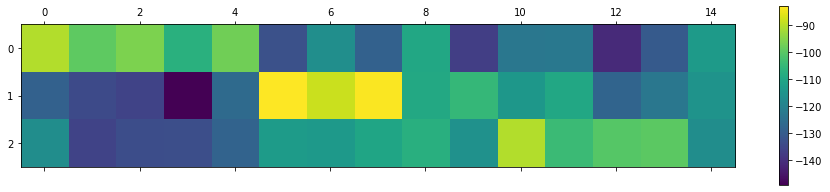

In [496]:
simulator.plot_gain_mat()

In [497]:
simulator.weighted_sum_rate_Gnats(Rx_powers_mW=[250 for i in range(len(simulator.x_Rx))], Rx_weights=np.ones(len(simulator.x_Rx)))

169.76944259362168

In [694]:
part = 'known'
gain_mat_mW = simulator.get_gain_mat(part=part, unit='mW')
max_power = 500

if part == 'unknown':
    Tx_idx_shift = len(simulator.x_Tx) - gain_mat_mW.shape[0]
    Rx_idx_shift = len(simulator.x_Rx) - gain_mat_mW.shape[1]
else:
    Tx_idx_shift = 0
    Rx_idx_shift = 0

Rx_powers_mW = np.random.uniform(1, 10, len(simulator.x_Rx))

power_wmmse = wmmse(
    simulator = simulator, 
    gain_mat_mW = gain_mat_mW,
    Rx_powers_mW = Rx_powers_mW,
    Rx_max_powers_mW = [max_power for i in range(gain_mat_mW.shape[1])],
    Rx_weights=np.ones(len(simulator.x_Rx)),
    Tx_idx_shift=Tx_idx_shift,
    Rx_idx_shift=Rx_idx_shift,
    max_iter=5000,
)

Weighted Sum Rate: 161.5523527770195 Convergence Error at Round 5000 0.0694792238703229


In [695]:
power_corr_mat = np.random.uniform(-0.5, 0.5, 
    (simulator.num_Tx_unknown*simulator.num_Rx_per_Tx_unknown, 
     simulator.num_Tx_known*simulator.num_Rx_per_Tx_known)
)
# power_corr_mat

In [718]:
num_power_samples = 100
observed_interferences_list = []
powers_list = []
for t, p_known in enumerate([np.random.uniform(0,max_power, gain_mat_mW.shape[1]) for i in range(num_power_samples)]):
    p_known = p_known 
    p_known = p_known.clip(min=0, max=max_power)
    p_unknown = power_corr_mat.dot(p_known).clip(min=0, max=max_power)
    # p_unknown = np.random.uniform(0,max_power, len(simulator.x_Rx)-gain_mat_mW.shape[1])
    p = np.append(p_known, p_unknown)
    powers_list.append(p)
    observed_interference = simulator.Rx_interference(p)[Rx_idx_shift: Rx_idx_shift+gain_mat_mW.shape[1]]
    observed_interferences_list.append(observed_interference)

In [719]:
# Train LR model
from sklearn.linear_model import LinearRegression

lr_train_X = pd.DataFrame(np.array(powers_list)[:, :gain_mat_mW.shape[1]])
observed_interference_data = pd.DataFrame(observed_interferences_list)

lr = []
for i in range(gain_mat_mW.shape[1]):
    lr_train_y = observed_interference_data[i]
    lr_i = LinearRegression().fit(lr_train_X, lr_train_y)
    lr.append(lr_i)

In [720]:
# Train synthetic control model
sc = []
sc_data_ = pd.DataFrame(observed_interferences_list) 
scaling_factor = 100 / sc_data_.mean().mean()
sc_data = sc_data_ * scaling_factor
for i in range(gain_mat_mW.shape[1]):
    sc_train_X = sc_data.drop(i, axis=1)
    sc_train_y = sc_data[i] 
    sc_i = SyntheticControl().fit(X=sc_train_X, y=sc_train_y)
    sc.append(sc_i)

In [721]:
sc_data.head(5)

,0,1,2,3,4,5,6,7,8,9
0,46.199849,1.759842,1.744758,0.997933,11.233781,105.205815,153.109286,195.300404,687.523644,53.593267
1,35.138659,1.210708,1.243751,0.766130,7.717219,81.043196,108.301110,150.286006,480.277078,41.316354
2,19.260341,1.178737,1.017411,0.391225,7.563424,40.540612,102.650285,75.981291,488.278642,20.507761
3,18.479876,1.192214,1.016092,0.371958,7.653246,37.858732,79.894123,70.690420,374.287049,19.203847
4,17.426666,1.339356,1.098347,0.338772,8.608953,33.953793,88.207486,63.673292,420.382895,17.168388


In [722]:
sc[0].coef_

array([2.50104209e-14, 2.48116824e-14, 1.15025581e-13, 5.26284082e-01,
       2.88084780e-01, 0.00000000e+00, 5.48966411e-14, 3.88517213e-15,
       1.85631138e-01])

In [723]:
def closest_power(p, p_list):
    p_list = np.asarray(p_list)
    dist = np.sum((p_list - p)**2, axis=1)
    return np.argmin(dist)


In [725]:
real_interf = []
sc_interf = []
lr_interf = []

for i in range(1000):

    # power_corr_mat = np.random.uniform(-0.5, 0.5, 
    #     (simulator.num_Tx_unknown*simulator.num_Rx_per_Tx_unknown, 
    #     simulator.num_Tx_known*simulator.num_Rx_per_Tx_known)
    # )

    # p_known = np.random.uniform(0, max_power, gain_mat_mW.shape[1])
    p_known = power_wmmse[:gain_mat_mW.shape[1]] 
    # p_unknown = power_corr_mat.dot(p_known[Rx_idx_shift: Rx_idx_shift+gain_mat_mW.shape[1]]).clip(min=0, max=max_power) 
    # p_unknown = [ 0 for i in range(len(simulator.x_Rx)-gain_mat_mW.shape[1])]
    p_unknown = np.random.uniform(0,max_power, len(simulator.x_Rx)-gain_mat_mW.shape[1])
    p = np.append(p_known, p_unknown)
    interferences = simulator.Rx_interference(p)
    split = simulator.num_Tx_known*simulator.num_Rx_per_Tx_known
    known_Rx_interferences = interferences[:split]
    unknown_Rx_interferences = interferences[split:]
    observed_interference_closest = observed_interferences_list[closest_power(p_known, np.array(powers_list)[:, :gain_mat_mW.shape[1]])]

    for i in range(gain_mat_mW.shape[1]):
        real_interf.append(known_Rx_interferences[i])
        sc_interf.append(sc[i].predict(pd.DataFrame(known_Rx_interferences).drop(i, axis=0)[0]))
        lr_interf.append(lr[i].predict([p_known]))

print('Real Interferences:', np.mean(real_interf))
print('SC Interference bias', (np.mean(sc_interf)-np.mean(real_interf))/np.mean(real_interf))
print('LR Interference bias', (np.mean(lr_interf)-np.mean(real_interf))/np.mean(real_interf))
    


Real Interferences: 5.1891496229604715e-09
SC Interference bias -0.2578675707532849
LR Interference bias -0.7370917240528321


5.173472218881829e-06